Задача: сравнить VOIP тарифы разных провайдеров

In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
from pandas import Series, DataFrame
from tqdm import tqdm
from importlib import reload
from os.path import join, normpath
import matplotlib.pyplot as plt

downloads = 'C:/Users/balob/Downloads'

### Вариант №1
##### Использование существующей трафиковой модели
<br>
Достоинства:
<br>
Относительно быстро работает
<br>
<br>
Недостатки:
<br>
Не учитываются все диапазоны тарифов

<br>
Добавить:
<br>
Прогресс бар для контроля выполнения.

<br>
Выгрузить из Splunk все вызовы (RreRequest=Update OR RreRequest=Terminate)
<br><br>
index=ocs Application=OCS_RRE ClientType=Pbx (RreRequest=Update OR RreRequest=Terminate) | table _time,Destination,VoipOperator,ChargeQuantity,ResellerCost,VoipOperator | where ChargeQuantity>0 AND VoipOperator=3

In [10]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import pandasql as ps
from os.path import join

# Загружаем файлы в DataFrame

downloads = 'C:/Users/balob/Downloads'
file_voip_usage = 'VOIP_USAGE_REP.csv'
file_voip_idt = 'ROAMABILITY Platinum 0938_Dec-13-2018 2602907324957423.csv'
file_voip_voxbeam = 'VOXBEAM_PLATINUM.csv'

# Переработка файла трафиковой модели

df_voip_usage = pd.read_csv(join(downloads,file_voip_usage),
                            usecols=['Destination','VoipOperator','ResellerCost','ChargeQuantity'])\
[['Destination','VoipOperator','ResellerCost','ChargeQuantity']]
df_voip_usage.columns = ['DIALED','VOIP_PROVIDER','VOIP_PRICE','QUANYITY']

# Если нужно задать отдельный номер
#df_voip_usage = DataFrame([['27717189257','TEST','10.9','10']],columns = ['DIALED','VOIP_PROVIDER','VOIP_PRICE','QUANYITY'])
#df_voip_usage = df_voip_usage.astype(dtype={'DIALED':'int64','VOIP_PRICE':'float64','QUANYITY':'float64'})

display(df_voip_usage.head())

# Переработка файла IDT

df_voip_idt = pd.read_csv(join(downloads,file_voip_idt),usecols=['Location Name','Dial Code','Platinum $ USD'])\
[['Location Name','Dial Code','Platinum $ USD']]
#df_voip_idt.columns = ['DEST_IDT','CODE_IDT','PRICE_IDT']
df_voip_idt.columns = ['DEST','CODE','PRICE']
display(df_voip_idt.head())

# Переработка файла Voxbeam

df_voip_voxbeam = pd.read_csv(join(downloads,file_voip_voxbeam),usecols=['Named Route Name','Prefix','New Rate'])\
[['Named Route Name','Prefix','New Rate']]
#df_voip_voxbeam.columns = ['DEST_VBM','CODE_VBM','PRICE_VBM']
df_voip_voxbeam.columns = ['DEST','CODE','PRICE']
display(df_voip_voxbeam.head())

# Для тестирования используем только часть данных
# !!! Закомментировать для реальных расчетов !!!

df_voip_usage = df_voip_usage.head(25)

# Функция для поиска best match прайсов для трафиковой модели

def left_join_best_match(df_usage,df_tariff,provider):
    simple_query = '''
    SELECT * FROM df_usage, df_tariff WHERE df_usage.DIALED LIKE df_tariff.CODE || '%'
    '''
    df_usage_with_voip_price = ps.sqldf(simple_query, locals())
    df_usage_with_voip_price['LEN'] = df_usage_with_voip_price.CODE.astype('str').str.len()

    df_usage_with_voip_price['MAX'] =\
    df_usage_with_voip_price.groupby([df_usage_with_voip_price['DIALED'],
                                    df_usage_with_voip_price['QUANYITY']])['LEN'].transform(np.max)
    df_usage_with_voip_price.rename(columns={'DEST':'DEST_'+provider,
                                             'CODE':'CODE_'+provider,
                                             'PRICE':'PRICE_'+provider}, inplace=True)
    df_usage_with_voip_price =\
    df_usage_with_voip_price[df_usage_with_voip_price['LEN']==df_usage_with_voip_price['MAX']]
    
    df_usage_with_voip_price['DIFF_'+provider] =\
    df_usage_with_voip_price[['VOIP_PRICE','PRICE_'+provider]].apply(lambda x: x['VOIP_PRICE'] - x['PRICE_'+provider], axis=1)
    
    df_usage_with_voip_price.drop(['DEST_'+provider,'MAX','LEN'],axis=1,inplace=True)
    
    return df_usage_with_voip_price

# Объединяем первого провайдера

df_voip_usage_idt = left_join_best_match(df_voip_usage,df_voip_idt,'IDT')

# Объединяем второго провайдера

df_usage_with_voip_price = left_join_best_match(df_voip_usage_idt,df_voip_voxbeam,'VBM')

# Результат

df_usage_with_voip_price.head()

,DIALED,VOIP_PROVIDER,VOIP_PRICE,QUANYITY
0,27812452170,1,0.1650,60
1,972542669900,100,0.0000,60
2,33623643968,1,0.0460,60
3,4917663268048,3,0.0138,60
4,263776215683,1,0.4022,60


,DEST,CODE,PRICE
0,Afghanistan,93,0.1272
1,Afghanistan Cellular-AT,9375,0.1636
2,Afghanistan Cellular-AWCC,9370,0.1727
3,Afghanistan Cellular-Etisalat,9373,0.1465
4,Afghanistan Cellular-Etisalat,9378,0.1465


,DEST,CODE,PRICE
0,Abkhazia Fixed,7840,0.1960
1,Abkhazia Mobile,7940,0.2450
2,Abkhazia Mobile - A-Mobile,79407,0.2450
3,Abkhazia Mobile - Aquafon,79409,0.2450
4,Afghanistan Fixed,93,0.2151


,DIALED,VOIP_PROVIDER,VOIP_PRICE,QUANYITY,CODE_IDT,PRICE_IDT,DIFF_IDT,CODE_VBM,PRICE_VBM,DIFF_VBM
1,27812452170,1,0.1650,60,27812,0.1650,0.0000,27812,0.1954,-0.0304
3,972542669900,100,0.0000,60,9725,0.0159,-0.0159,97254,0.0171,-0.0171
6,33623643968,1,0.0460,60,3362,0.0460,0.0000,3362,0.0575,-0.0115
9,4917663268048,3,0.0138,60,49176,0.2115,-0.1977,49176,0.0138,0.0000
11,263776215683,1,0.4022,60,26377,0.4022,0.0000,26377,0.4136,-0.0114


In [ ]:
def calculate_quantity(df):
    return df.values.sum()/60
    
df_temp = df_usage_with_voip_price.groupby(['CODE_IDT','CODE_VBM','PRICE_IDT','PRICE_VBM'],as_index=False)['QUANYITY'].\
                                                                                            agg(calculate_quantity)

def calculate_cost(df):
    df['COST_IDT'] = df.PRICE_IDT * df.QUANYITY
    df['COST_VBM'] = df.PRICE_VBM * df.QUANYITY
    df['DIFF'] = df.PRICE_IDT - df.PRICE_VBM
    return df

df = df_temp.apply(calculate_cost,axis=1)
df.to_csv(join(downloads,'RESULT.csv'),index=False)
df.head()

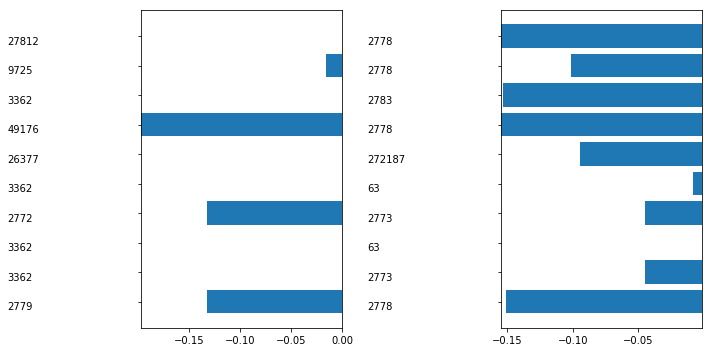

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# две столбиковые диаграммы:
for col in [0, 1]:
    start = col * 10
    end = (col + 1) * 10
    ax[col].barh(np.arange(10), df_usage_with_voip_price['DIFF_IDT'].iloc[start:end])
    ax[col].set_yticks(np.arange(10))
    ax[col].set_yticklabels(df_usage_with_voip_price['CODE_IDT'].iloc[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(min(df_usage_with_voip_price['DIFF_IDT'].iloc[start:end]),
                     max(df_usage_with_voip_price['DIFF_IDT'].iloc[start:end]))
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()
plt.show()

In [16]:
df_usage_with_voip_price['DIFF_IDT'].iloc[5:15]

14    0.000000
16   -0.132500
19    0.000000
22    0.000000
24   -0.132500
26   -0.155001
28   -0.101001
30   -0.153000
32   -0.155001
33   -0.094435
Name: DIFF_IDT, dtype: float64

### Вариант №2
##### Использование полной, сгенерированной трафиковой модели
<br>
Достоинства:
<br>
Очень медленно работает
<br>
<br>
Недостатки:
<br>
Учитываются все диапазоны тарифов
<br>

Добавить:
<br>

In [3]:
#Из базы данных OCS выгрузить все диапазоны провайдера с добавлением длины каждого диапазона

import pandas as pd
import pyodbc 
#Connect to OCSDBREP1 (BSS)
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=172.18.11.82;DATABASE=10028;UID=BSS;PWD=iKQVm40AZAmyRaw72LeY')

sql_srt=\
'''
SELECT
international_rule_id,international_plan_id,COUNTRY_CODE,COUNTRY_GROUP,PREFIX,PRICE
FROM INTERNATIONAL_RULES WHERE international_plan_id IN (14)
'''

df_int_14 = pd.read_sql_query(sql_srt, cnxn)
df_int_14['international_rule_id']=df_int_14['international_rule_id'].astype('int')
df_int_14['international_plan_id']=df_int_14['international_plan_id'].astype('int')
cnxn.close()

df_byc = DataFrame(columns=['COUNTRY_CODE','COUNTRY_GROUP','CODE','PRICE'])
df_byc[['COUNTRY_CODE','COUNTRY_GROUP','CODE','PRICE']] = df_int_14[['COUNTRY_CODE','COUNTRY_GROUP','PREFIX','PRICE']] .copy()

df_byc['LEN'] = df_byc.CODE.astype('str').str.len()
df_byc.head()

,COUNTRY_CODE,COUNTRY_GROUP,CODE,PRICE,LEN
0,881,OTHER,881,2.0,3
1,881,OTHER,8810,2.0,4
2,881,OTHER,8811,2.0,4
3,881,OTHER,8812,2.0,4
4,881,OTHER,8813,2.0,4


In [4]:
# Сгенерировать все диапазоны для каждого Country Code

# Убраь head в запросе диапазонов цикла
range_list = []
for COUNTRY_CODE,LEN in df_byc.groupby(['COUNTRY_CODE'],as_index=False)['LEN'].max().head().values:
    range_start = int(str(str(COUNTRY_CODE)+'0'*LEN))
    range_end = int(str(str(COUNTRY_CODE)+'9'*LEN))
    range_list.append([range_start,range_end])
range_list

[[10000000, 19999999],
 [700000000, 799999999],
 [2000000, 2099999],
 [2700000000000, 2799999999999],
 [3000000, 3099999]]

In [5]:
# Сгенерировать все диапазоны трафиковой модели с добавлением длины и поддиапазона для каждого номера

# Пример
range_list = [[10,19],[30,39]]

tm_list = [['DEST','DEST_LEN','DEST_RANGE']]

#range_list = [[10,19],[30,39]]

def generate_tm_list(v_range_start,v_range_end):
    for dest in range(v_range_start,v_range_end):
        for dest_len in range(1,len(str(dest))+1):
            tm_list.append([dest,dest_len,str(dest)[:dest_len]])
    return tm_list

for range_start,range_end in tqdm(range_list):
    tm_list.append(generate_tm_list(range_start,range_end))
tm_list[:10]

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2003.01it/s]


[['DEST', 'DEST_LEN', 'DEST_RANGE'],
 [10, 1, '1'],
 [10, 2, '10'],
 [11, 1, '1'],
 [11, 2, '11'],
 [12, 1, '1'],
 [12, 2, '12'],
 [13, 1, '1'],
 [13, 2, '13'],
 [14, 1, '1']]

### Вариант №3
##### Поиск пересекащихся прайсов

Идея варианта.
Для каждого диапазона доного тарифного плана возможен только один из следующих вариантов пересечения с диапазонами другого тарифного плана:

<ol>
<li>Есть диапазон такой же длины.</li>
680 - 680
<li>Есть диапазон такой же длины и диапазоны большей длины.</li>
680 - 680<br>
680 - 6801
<li>Нет диапазона такой же длины, но есть диапазоны большей длины.</li>
680 - 6801<br>
680 - 68
<li>Нет диапазона такой же длины и нет диапазонов большей длины.</li>
680 - 68
</ol>
<br>
Достоинства:
<br>
<br>
Недостатки:
<br>
<ol>
<li>В случае, если нужно сравнивать группу диапазонов, например, для "Roamability VoIP Charge By Country", и если существуют пересекающиеся диапазоны в разных группах, то расчет буте не верный.</li>
Например:<br>
USA 1 - 1<br>
USA 123 - 1234<br>
Canada 1680 - 1<br>
Canada 1680 - 116801<br>
<li>В случае, если в тарифном плане одного оператора не показаны некоторые завышенные тарифы, а в другом тарифном плане показаны, то расчет будет некорректный.</li>
Например:<br>
680:0.5\$ - 680:0.5\$<br>
680:0.5\$ - 6801:10\$<br>
6801:10\$ - скрыт<br>
</ol>
<br>
Добавить:
<br>

In [ ]:
%reset -f